# Imports

In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
from matplotlib import pyplot as plt
import torchvision
from torch.nn import functional as F
import re
import collections
import math
from torch.utils.data import DataLoader

# Visualization

In [5]:
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5),
                  cmap='Reds'):
    """Show heatmaps of matrices."""
    num_rows, num_cols = matrices.shape[:2]
    
    # Create figure with subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize,
                            sharex=True, sharey=True, squeeze=False)
    
    # Plot each heatmap
    for i in range(num_rows):
        for j in range(num_cols):
            ax = axes[i, j]
            pcm = ax.imshow(matrices[i, j].detach().cpu().numpy(), cmap=cmap)
            
            # Remove ticks for cleaner look
            ax.set_xticks([])
            ax.set_yticks([])
        
            # Add labels only where needed
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    
    # Add colorbar
    plt.colorbar(pcm, ax=axes.ravel().tolist())

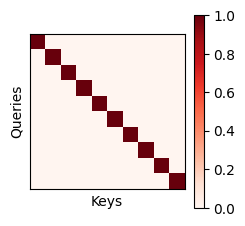

In [6]:
attention_weights = torch.eye(10).reshape((1, 1, 10, 10))
show_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')

# Attention Pooling By Similarity

## Kernels and Data

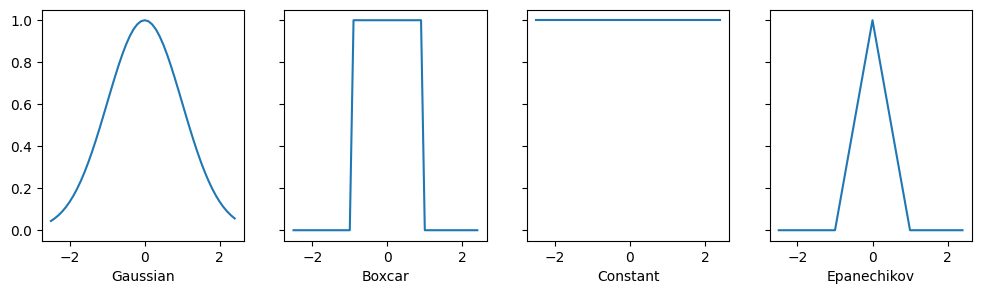

In [7]:
# Define some kernels
def gaussian(x):
    return torch.exp(-x**2 / 2)

def boxcar(x):
    return torch.abs(x) < 1.0

def constant(x):
    return 1.0 + 0 * x

def epanechikov(x):
    return torch.max(1 - torch.abs(x), torch.zeros_like(x))

fig, axes = plt.subplots(1, 4, sharey=True, figsize=(12, 3))

kernels = (gaussian, boxcar, constant, epanechikov)
names = ('Gaussian', 'Boxcar', 'Constant', 'Epanechikov')
x = torch.arange(-2.5, 2.5, 0.1)
for kernel, name, ax in zip(kernels, names, axes):
    ax.plot(x.detach().numpy(), kernel(x).detach().numpy())
    ax.set_xlabel(name)

plt.show()


## Attention Pooling via Nadaraya–Watson Regression

To see Nadaraya–Watson estimation in action, let’s define some training data. In the following we use the dependency where is drawn from a normal distribution with zero mean and unit variance. We draw 40 training examples.

In [9]:
def f(x):
    return 2 * torch.sin(x) + x

n = 40
x_train, _ = torch.sort(torch.rand(n) * 5)
y_train = f(x_train) + torch.randn(n)
x_val = torch.arange(0, 5, 0.1)
y_val = f(x_val)

Calculating attention weights

In [11]:
def nadaraya_watson(x_train, y_train, x_val, kernel):
    dists = x_train.reshape((-1, 1)) - x_val.reshape((1, -1))
    # Each column/row corresponds to each query/key
    k = kernel(dists).type(torch.float32)
    # Normalization over keys for each query
    attention_w = k / k.sum(0)
    y_hat = y_train@attention_w
    return y_hat, attention_w

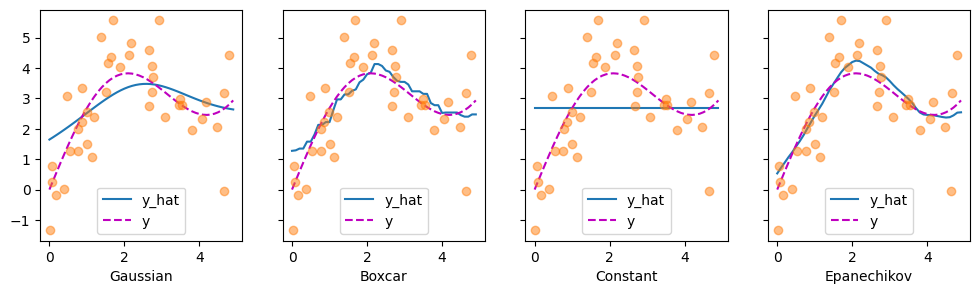

In [12]:
def plot(x_train, y_train, x_val, y_val, kernels, names, attention=False):
    fig, axes = plt.subplots(1, 4, sharey=True, figsize=(12, 3))
    for kernel, name, ax in zip(kernels, names, axes):
        y_hat, attention_w = nadaraya_watson(x_train, y_train, x_val, kernel)
        if attention:
            pcm = ax.imshow(attention_w.detach().numpy(), cmap='Reds')
        else:
            ax.plot(x_val, y_hat)
            ax.plot(x_val, y_val, 'm--')
            ax.plot(x_train, y_train, 'o', alpha=0.5);
        ax.set_xlabel(name)
        if not attention:
            ax.legend(['y_hat', 'y'])
    if attention:
        fig.colorbar(pcm, ax=axes, shrink=0.7)

plot(x_train, y_train, x_val, y_val, kernels, names)

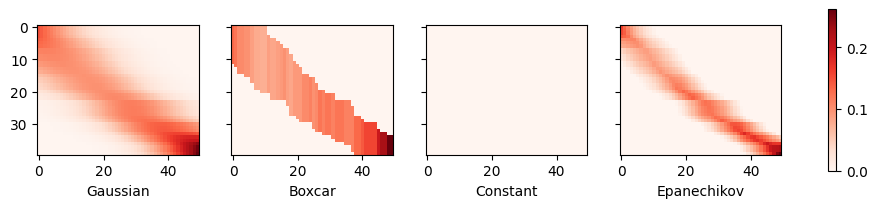

In [13]:
plot(x_train, y_train, x_val, y_val, kernels, names, attention=True)

The estimates for the Gaussian, Boxcar, and Epanechikov kernels are similar. They contain similar attention weights despite coming from different fuctional forms of the kernel

## Adapting Attention Pooling

We can replce the Gaussian Kernel with a similar one with a different width. For this case, let us use the kernel $\alpha(\vec{q}, \vec{k}) = exp(-1/2\sigma^2 \left \lVert \vec{q} - \vec{k} \right \rVert^2)$ where $\sigma^2$ determines the width of the kernel

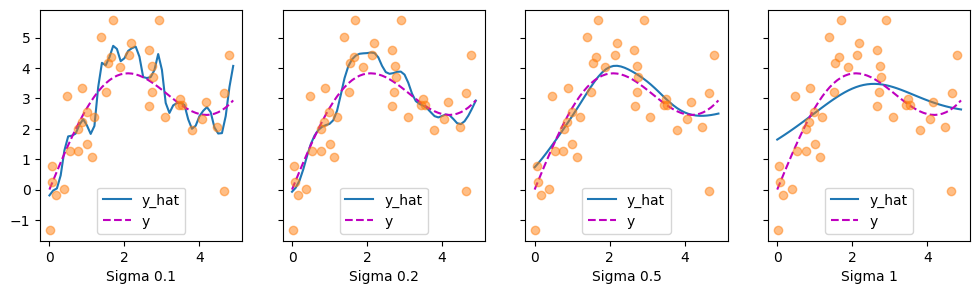

In [14]:
sigmas = (0.1, 0.2, 0.5, 1)
names = ['Sigma ' + str(sigma) for sigma in sigmas]

def gaussian_with_width(sigma):
    return (lambda x: torch.exp(-x**2 / (2*sigma**2)))

kernels = [gaussian_with_width(sigma) for sigma in sigmas]
plot(x_train, y_train, x_val, y_val, kernels, names)

The narrower the width of the kernel, the less smooth the estimate but they do adapt better to local variations

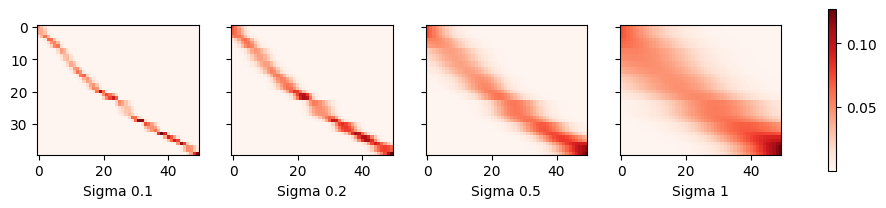

In [15]:
plot(x_train, y_train, x_val, y_val, kernels, names, attention=True)

The narrower the kernel, the narrow the large attention weights are

# Attention Scoring Functions

Since dot product is easier to calculate as compared to distance functions, we can try to come to a dot product attention function

Considering the gaussian attention without exponentiation, $a(\vec{q}, \vec{k_i}) = -\frac{1}{2} \left \Vert \vec{q} - \vec{k_i} \right \Vert^2 = \vec{q}^\top\vec{k_i} - \frac{1}{2} \left \Vert \vec{k_i} \right \Vert^2 - \frac{1}{2} \left \Vert \vec{q} \right \Vert^2$

Assuming that normalizations would cause the $\frac{1}{2} \left \Vert \vec{q} \right \Vert^2$ term to disappear and constant values of $\left \Vert \vec{k_i} \right \Vert$ due to batch and layer normalization would ensure that the terms removal will have no major change in the outcome, we come to a dot product kernel. We scale it by $\frac{1}{\sqrt{d}}$

$\alpha(\vec{q}, \vec{k_i}) = softmax(a(\vec{q}, \vec{k_i})) = \frac{exp(\vec{q}\top \vec{k_i} / \sqrt{d})}{\sum_i exp(\vec{q}\top \vec{k_j} / \sqrt{d})}$

## Masked Softmax Operation

The implementation cheats ever so slightly by setting the values of $v_i$ for $i\geq l$, to zero. Moreover, it sets the attention weights to a large negative number, such as $-10^6$ in order to make their contribution to gradients and values vanish in practice. This is done since linear algebra kernels and operators are heavily optimized for GPUs and it is faster to be slightly wasteful in computation rather than to have code with conditional (if then else) statements.

In [16]:
def masked_softmax(X, valid_lens):
    """Perform softmax operation by masking elements on the last axis."""
    # X: 3D tensor, valid_lens: 1D or 2D tensor
    def _sequence_mask(X, valid_len, value=0):
        maxlen = X.size(1)
        mask = torch.arange((maxlen), dtype=torch.float32,
                            device=X.device)[None, :] < valid_len[:, None]
        X[~mask] = value
        return X

    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # On the last axis, replace masked elements with a very large negative
        # value, whose exponentiation outputs 0
        X = _sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

In [19]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.4520, 0.5480, 0.0000, 0.0000],
         [0.6029, 0.3971, 0.0000, 0.0000]],

        [[0.4477, 0.3349, 0.2174, 0.0000],
         [0.3881, 0.3871, 0.2248, 0.0000]]])

In [20]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.3923, 0.2313, 0.3763, 0.0000]],

        [[0.3229, 0.6771, 0.0000, 0.0000],
         [0.1538, 0.2450, 0.3251, 0.2761]]])

## Batch Matrix Multiplication

In [22]:
Q = torch.ones((2, 3, 4))
K = torch.ones((2, 4, 6))
result = torch.bmm(Q, K)
print(f"Shape of batch matrix multiplication result: {result.shape}")
# Verify if shape matches expected (2, 3, 6)
assert result.shape == (2, 3, 6), f"Expected shape (2, 3, 6), but got {result.shape}"

Shape of batch matrix multiplication result: torch.Size([2, 3, 6])
